Importando as bibliotecas para o tratamento e visualização dos dados.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import holidays
import datetime
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.holtwinters import ExponentialSmoothing

Realizando a leitura da base de dados.

In [2]:
df: pd.DataFrame = pd.read_excel('data/01 Call-Center-Dataset.xlsx')
df.head()

,Call Id,Agent,Date,Time,Topic,Answered (Y/N),Resolved,Speed of answer in seconds,AvgTalkDuration,Satisfaction rating
0,ID0001,Diane,2021-01-01,09:12:58,Contract related,Y,Y,109.0,00:02:23,3.0
1,ID0002,Becky,2021-01-01,09:12:58,Technical Support,Y,N,70.0,00:04:02,3.0
2,ID0003,Stewart,2021-01-01,09:47:31,Contract related,Y,Y,10.0,00:02:11,3.0
3,ID0004,Greg,2021-01-01,09:47:31,Contract related,Y,Y,53.0,00:00:37,2.0
4,ID0005,Becky,2021-01-01,10:00:29,Payment related,Y,Y,95.0,00:01:00,3.0


Contando a quantidade de chamadas recebidas por dia.

In [3]:
dayly: pd.DataFrame = df[['Call Id', 'Date']].groupby('Date').count()
dayly.rename(columns={'Call Id': 'Calls'}, inplace=True)
dayly.index = pd.to_datetime(dayly.index)

dayly.head()

,Calls
Date,
2021-01-01,58
2021-01-02,60
2021-01-03,58
2021-01-04,54
2021-01-05,56


Visualização inicial dos dados.

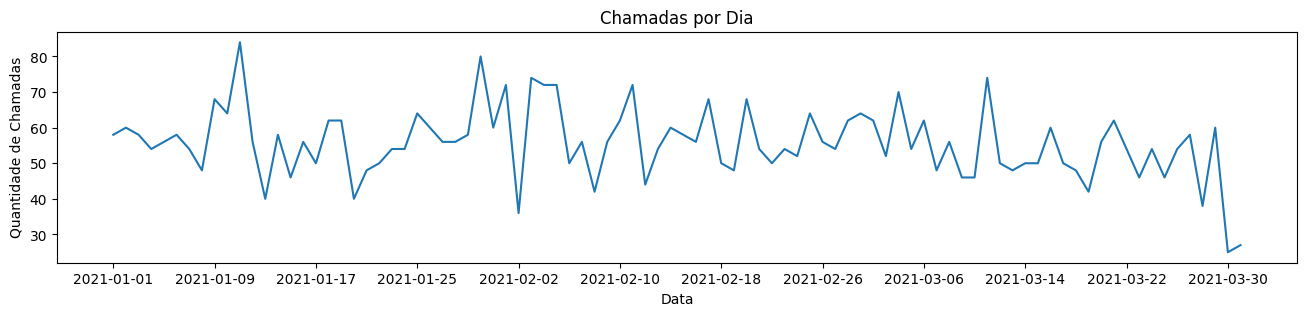

In [4]:
plt.figure(figsize=(16, 3))
plt.plot(dayly.index, dayly['Calls'])
plt.xlabel('Data')
plt.ylabel('Quantidade de Chamadas')
plt.title('Chamadas por Dia')
plt.xticks(dayly.index[::8])
plt.show()

Estatísticas básicas das chamadas diárias:

In [5]:
dayly.describe()

,Calls
count,90.000000
mean,55.555556
std,10.131840
min,25.000000
25%,50.000000
50%,56.000000
75%,61.500000
max,84.000000


Calculando a média de chamadas por dia da semana.

In [6]:
weekly_means: pd.DataFrame = dayly.copy()
weekly_means['Day_name'] = weekly_means.index.day_name()
weekly_means = weekly_means.groupby('Day_name').mean()
weekly_means = weekly_means.reindex(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
weekly_means.rename(columns={'Calls': 'Mean Calls'}, inplace=True)

weekly_means

,Mean Calls
Day_name,
Sunday,55.076923
Monday,59.230769
Tuesday,51.923077
Wednesday,52.230769
Thursday,59.333333
Friday,52.307692
Saturday,59.076923


Visualizando em grafico de barras.

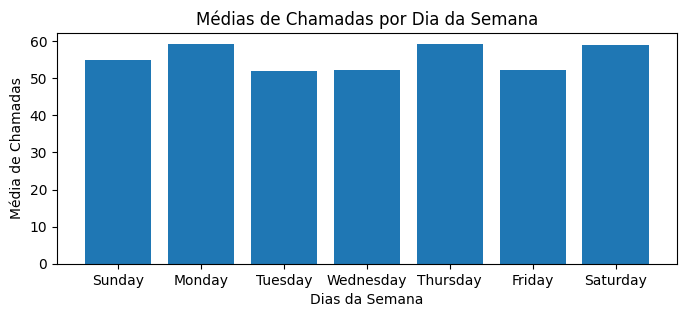

In [7]:
plt.figure(figsize=(8, 3))
plt.bar(weekly_means.index, weekly_means['Mean Calls'])
plt.xlabel('Dias da Semana')
plt.ylabel('Média de Chamadas')
plt.title('Médias de Chamadas por Dia da Semana')
plt.show()

Feriados brasileiros do ano de 2021

In [8]:
us_holidays: holidays.US = holidays.US(years=2021)

us_holiday_df: pd.DataFrame = pd.DataFrame.from_dict(us_holidays.items())
us_holiday_df.columns = ['Date', 'Holiday']
us_holiday_df['Date'] = pd.to_datetime(us_holiday_df['Date'])
us_holiday_df.set_index('Date', inplace=True)
us_holiday_df.sort_index(inplace=True)

us_holiday_df

,Holiday
Date,
2021-01-01,New Year's Day
2021-01-18,Martin Luther King Jr. Day
2021-02-15,Washington's Birthday
2021-05-31,Memorial Day
2021-06-18,Juneteenth National Independence Day (observed)
2021-06-19,Juneteenth National Independence Day
2021-07-04,Independence Day
2021-07-05,Independence Day (observed)
2021-09-06,Labor Day


In [9]:
holydays_observed: pd.DataFrame = us_holiday_df.merge(dayly, how='inner', on='Date')

holydays_observed

,Holiday,Calls
Date,,
2021-01-01,New Year's Day,58
2021-01-18,Martin Luther King Jr. Day,62
2021-02-15,Washington's Birthday,58


In [12]:
# Separando os dados em treino e teste (últimas 2 semanas)
train = dayly[:-14]
test = dayly[-14:]

# Criando features para o modelo
train_features = pd.DataFrame({
    'day_of_week': train.index.dayofweek,
    'day_of_month': train.index.day,
    'month': train.index.month,
    'is_holiday': train.index.isin(us_holiday_df.index)
})

test_features = pd.DataFrame({
    'day_of_week': test.index.dayofweek,
    'day_of_month': test.index.day,
    'month': test.index.month,
    'is_holiday': test.index.isin(us_holiday_df.index)
})

Best model: Multiplicative trend, Additive seasonal
MSE: 160.92
R²: -0.31


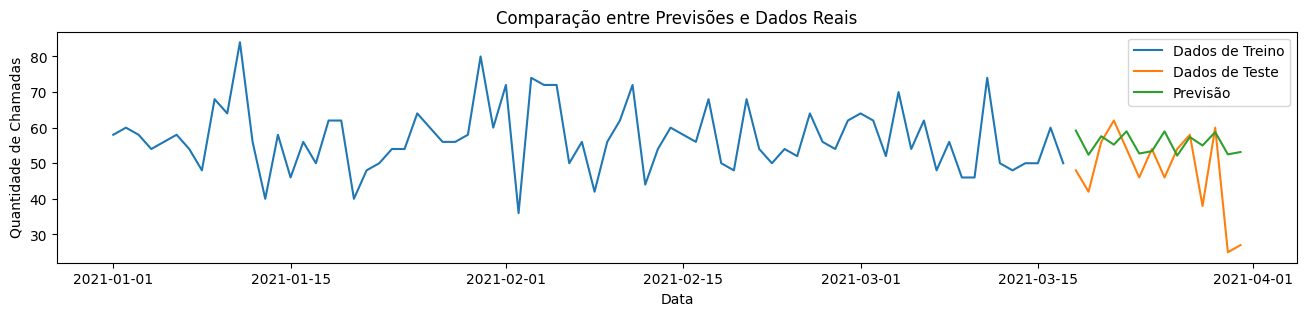

In [13]:
# Test different Holt-Winters configurations
models = {
    'Additive trend, Additive seasonal': ExponentialSmoothing(
        train['Calls'].asfreq('D'), seasonal_periods=7, trend='add', seasonal='add'
    ).fit(),
    'Additive trend, Multiplicative seasonal': ExponentialSmoothing(
        train['Calls'].asfreq('D'), seasonal_periods=7, trend='add', seasonal='mul'
    ).fit(),
    'Multiplicative trend, Additive seasonal': ExponentialSmoothing(
        train['Calls'].asfreq('D'), seasonal_periods=7, trend='mul', seasonal='add'
    ).fit(),
    'Multiplicative trend, Multiplicative seasonal': ExponentialSmoothing(
        train['Calls'].asfreq('D'), seasonal_periods=7, trend='mul', seasonal='mul'
    ).fit(),
    'Damped Additive trend, Additive seasonal': ExponentialSmoothing(
        train['Calls'].asfreq('D'), seasonal_periods=7, trend='add', seasonal='add', damped_trend=True
    ).fit(),
    'Damped Additive trend, Multiplicative seasonal': ExponentialSmoothing(
        train['Calls'].asfreq('D'), seasonal_periods=7, trend='add', seasonal='mul', damped_trend=True
    ).fit()
}

# Make predictions
forecasts = {}
for name, model in models.items():
    # Make predictions for test period
    predictions = model.forecast(len(test))
    
    # Calculate metrics
    mse = mean_squared_error(test['Calls'], predictions)
    r2 = r2_score(test['Calls'], predictions)
    
    # Store results
    forecasts[name] = {
        'predictions': predictions,
        'mse': mse,
        'r2': r2
    }

# Find best model
best_mse = float('inf')
best_model = None
for name, results in forecasts.items():
    if results['mse'] < best_mse:
        best_mse = results['mse']
        best_model = name

print(f'Best model: {best_model}')
print(f'MSE: {best_mse:.2f}')
print(f'R²: {forecasts[best_model]['r2']:.2f}')

# Plot the results
plt.figure(figsize=(16, 3))
plt.plot(train.index, train['Calls'], label='Dados de Treino')
plt.plot(test.index, test['Calls'], label='Dados de Teste')
plt.plot(test.index, forecasts[best_model]['predictions'], label='Previsão')
plt.xlabel('Data')
plt.ylabel('Quantidade de Chamadas')
plt.title('Comparação entre Previsões e Dados Reais')
plt.legend()
plt.show()